# Additional End of week Exercise - week 2

Now use everything you've learned from Week 2 to build a full prototype for the technical question/answerer you built in Week 1 Exercise.

This should include a Gradio UI, streaming, use of the system prompt to add expertise, and the ability to switch between models. Bonus points if you can demonstrate use of a tool!

If you feel bold, see if you can add audio input so you can talk to it, and have it respond with audio. ChatGPT or Claude can help you, or email me if you have questions.

I will publish a full solution here soon - unless someone beats me to it...

There are so many commercial applications for this, from a language tutor, to a company onboarding solution, to a companion AI to a course (like this one!) I can't wait to see your results.

In [1]:
from openai import OpenAI
import gradio as gr
import os
from dotenv import load_dotenv
import json

# Step 1: Setting up the environemt

In [2]:
# Check if code can reach OpenAI API key

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

OpenAI API Key exists and begins sk-proj-


In [3]:
system_prompt = "You are a helpful assistant for a chef. Ensure that the responses are concise. Your job is to help the chef organize his recipes"
openai = OpenAI()
model = 'gpt-5-mini'


# Step 2: Create the tools that will interface with the AI


In [4]:
get_recipe_function = {
    'name': 'get_recipe_function',
    'description': 'get the recipe and its ingredients',
    'parameters': {
        'type': 'object',
        'properties':{
            'recipe_name': {
                'type': 'string',
                'description':'the name of the recipe'
            },
            'quantity': {
                'type': 'integer',
                'description': 'the quantity of the recipe'
            },
        },
        'required': ['recipe_name'],
        'additionalProperties': False
    }
}

set_recipe_function = {
    'name': 'set_recipe_function',
    'description': 'set the recipe and its ingredients',
    'parameters': {
        'type': 'object',
        'properties':{
            'recipe_name': {
                'type': 'string',
                'description':'the name of the recipe'
            },
            'quantity': {
                'type': 'integer',
                'description': 'the quantity of the recipe'
            },
        },
        'required': ['recipe_name', 'ingredients_list'],
        'additionalProperties': False
    }
}

In [5]:
tools = [{"type": "function", "function": get_recipe_function}, {"type": "function", "function": set_recipe_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_recipe_function',
   'description': 'get the recipe and its ingredients',
   'parameters': {'type': 'object',
    'properties': {'recipe_name': {'type': 'string',
      'description': 'the name of the recipe'},
     'quantity': {'type': 'integer',
      'description': 'the quantity of the recipe'}},
    'required': ['recipe_name'],
    'additionalProperties': False}}},
 {'type': 'function',
  'function': {'name': 'set_recipe_function',
   'description': 'set the recipe and its ingredients',
   'parameters': {'type': 'object',
    'properties': {'recipe_name': {'type': 'string',
      'description': 'the name of the recipe'},
     'quantity': {'type': 'integer',
      'description': 'the quantity of the recipe'}},
    'required': ['recipe_name', 'ingredients_list'],
    'additionalProperties': False}}}]

# Step 3: Creating functions to create chat interface and integrate tools into AI API

In [6]:
def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(
        model=model, 
        messages=messages, 
        tools=tools
    )

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_call(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=model, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [21]:
quantity = get_recipe_function("Pizza")

DATABASE TOOL CALLED: Getting price for Pizza


In [24]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for pizza


Traceback (most recent call last):
  File "/Users/hisham/projects/llm_engineering/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 745, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hisham/projects/llm_engineering/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hisham/projects/llm_engineering/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hisham/projects/llm_engineering/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 1621, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hisham/projects/llm_engineering/.venv/lib/python3.12/site-pac

In [8]:
def handle_tool_call(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_recipe_function":
            arguments = json.loads(tool_call.function.arguments)
            recipe_name = arguments.get('recipe_name')
            print(recipe_name)
            recipe = get_recipe_function(recipe_name)
            responses.append ({
                "role": "tool",
                "content": recipe,
                "tool_call_id": tool_call.id
            })
        elif tool_call.function.name == "set_recipe_function":
            arguments = json.loads(tool_call.function.arguments)
            recipe_name = arguments.get('recipe_name')
            quantity = arguments.get('quantity')
            recipe = set_recipe_function(recipe_name, quantity)
            responses.append({
                "role": "tool",
                "content": recipe,
                "tool_call_id": tool_call.id
            })
    return responses



# Step 4: Create SQL database that AI can interact with + related functions

In [9]:
import sqlite3

In [10]:
DB = "recipes.db"

with sqlite3.connect(DB) as conn:
    cursor = conn.cursor()
    cursor.execute('CREATE TABLE IF NOT EXISTS recipes (recipe TEXT PRIMARY KEY, quantity REAL)')
    conn.commit()

In [11]:
def get_recipe_function(recipe):
    print(f"DATABASE TOOL CALLED: Getting price for {recipe}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT quantity FROM recipes WHERE recipe = ?', (recipe.lower(),))
        result = cursor.fetchone()
        return f"Quantity of {recipe} is {result[0]}" if result else "No quantity for this recipe"

In [12]:
def set_recipe_function(recipe, quantity):
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('INSERT INTO recipes (recipe, quantity) VALUES (?, ?) ON CONFLICT(recipe) DO UPDATE SET quantity = ?', (recipe.lower(), quantity, quantity))
        conn.commit()

## Populate database

In [33]:
recipe_quantities = {"pizza":10, "burger": 10,}
for recipe, quantity in recipe_quantities.items():
    set_recipe_function(recipe, quantity)

get_recipe_function('burger')

DATABASE TOOL CALLED: Getting price for burger


'Quantity of burger is 10.0'

DATABASE TOOL CALLED: Getting price for burger


# Step 5: Create multi-modal functions

In [14]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [15]:
# Image generator
def artist(recipe):
    image_response = openai.images.generate(
        model='dall-e-3',
        prompt=f'An image of the given recipe: {recipe}. Make the design look extra delicious.',
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )

    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

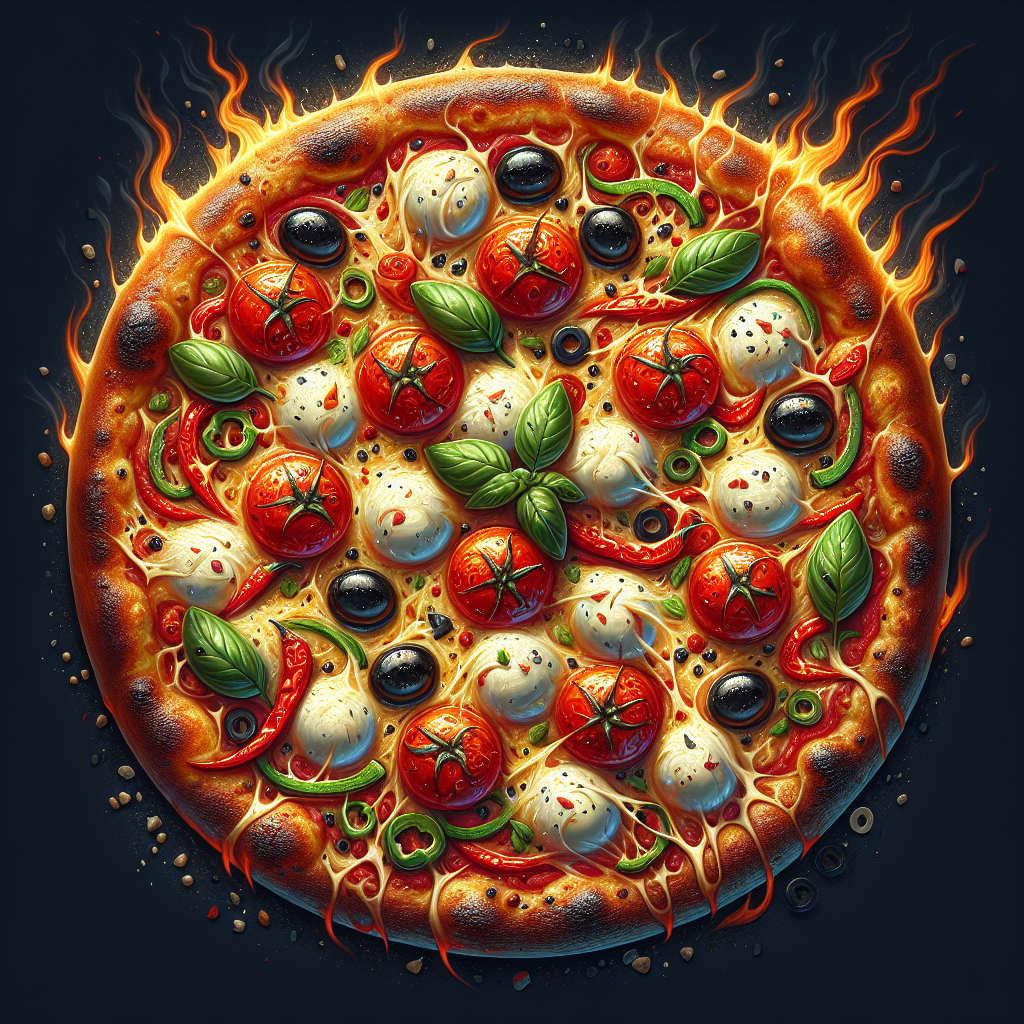

In [16]:
image = artist("Pizza")
display(image)

In [17]:
# audio generator

def talker(message):
    response = openai.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

In [28]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_prompt}] + history
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)
    recipes = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, recipes = handle_tool_call(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=model, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if recipes:
        image = artist(recipes[0])
    
    return history, voice, image


In [31]:
def handle_tool_call(message):
    recipes = []
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_recipe_function":
            arguments = json.loads(tool_call.function.arguments)
            recipe_name = arguments.get('recipe_name')
            recipe = get_recipe_function(recipe_name)
            recipes.append(recipe)
            responses.append ({
                "role": "tool",
                "content": recipe,
                "tool_call_id": tool_call.id
            })
        elif tool_call.function.name == "set_recipe_function":
            arguments = json.loads(tool_call.function.arguments)
            recipe_name = arguments.get('recipe_name')
            quantity = arguments.get('quantity')
            recipe = set_recipe_function(recipe_name, quantity)
            recipes.append(recipe)
            responses.append({
                "role": "tool",
                "content": recipe,
                "tool_call_id": tool_call.id
            })
        return responses, recipes



In [ ]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True)



* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for pizza
DATABASE TOOL CALLED: Getting price for burgers
